In [9]:
import pennylane as qml
import pennylane.numpy as qnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from numpy import count_nonzero
from pruning import optimize_and_prune

rc('text', usetex=True)
%load_ext autoreload
%autoreload 2

In [3]:
def ansatz(rotations, wires):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
        qml.broadcast(qml.CZ, pattern='chain', wires=range(wires))
    return qml.probs(wires=range(wires))

In [4]:
def global_cost_ckt(ckt, rots, wires):
    return 1 - gckt(rots, wires)[0]

In [5]:
def optimize(cost_fn, ckt,  params, nwires, steps=100, tol=0.1):
    params = qnp.array(params, requires_grad=True)
    # print(params.shape)
    opt = qml.GradientDescentOptimizer(stepsize=0.2)
    steps = 100
    opt_steps = []
    costs = [] 
    costs.append(cost_fn(ckt, params, nwires))
    for i in range(steps):
        _, params, _ = opt.step(cost_fn, ckt, params, nwires)
        costs.append(cost_fn(ckt, params, nwires))
        opt_steps.append(i)
        if i % 5 == 0:
            print(f"Step :{i} | Cost: {cost_fn(ckt, params, nwires)}")
        if cost_fn(ckt, params, nwires) < tol:
            break
    if not opt_steps:
        opt_steps.append(0) # check if we converge super quickly
    return params,costs, opt_steps

In [6]:
qubits = list(range(2, 11))
def get_rotations_unif(nwires):
    rots = [[np.random.uniform(-np.pi, np.pi) for _ in range(nwires)], 
            [np.random.uniform(-np.pi, np.pi) for _ in range(nwires)]]
    return rots

In [7]:
dense_param_runs = {}
for q in qubits:
    print("~"*20+ f"Qubit -> {q}" + "~"*20)
    gckt = qml.QNode(ansatz, device=qml.device('default.qubit', wires=q, shots=10000), interface='autograd')
    params = get_rotations_unif(q)
    popt, costs, steps = optimize(global_cost_ckt, gckt, params, q)
    dense_param_runs[q] = costs

~~~~~~~~~~~~~~~~~~~~Qubit -> 2~~~~~~~~~~~~~~~~~~~~
Step :0 | Cost: 0.5816
Step :5 | Cost: 0.4861
Step :10 | Cost: 0.35719999999999996
Step :15 | Cost: 0.21130000000000004
Step :20 | Cost: 0.1028
~~~~~~~~~~~~~~~~~~~~Qubit -> 3~~~~~~~~~~~~~~~~~~~~
Step :0 | Cost: 0.7595000000000001
Step :5 | Cost: 0.6623
Step :10 | Cost: 0.5331
Step :15 | Cost: 0.3568
Step :20 | Cost: 0.20020000000000004
~~~~~~~~~~~~~~~~~~~~Qubit -> 4~~~~~~~~~~~~~~~~~~~~
Step :0 | Cost: 0.9125
Step :5 | Cost: 0.906
Step :10 | Cost: 0.8962
Step :15 | Cost: 0.8785000000000001
Step :20 | Cost: 0.8581
Step :25 | Cost: 0.8439
Step :30 | Cost: 0.8093
Step :35 | Cost: 0.7811
Step :40 | Cost: 0.7175
Step :45 | Cost: 0.6328
Step :50 | Cost: 0.5153
Step :55 | Cost: 0.34730000000000005
Step :60 | Cost: 0.19430000000000003
Step :65 | Cost: 0.07920000000000005
~~~~~~~~~~~~~~~~~~~~Qubit -> 5~~~~~~~~~~~~~~~~~~~~
Step :0 | Cost: 0.9757
Step :5 | Cost: 0.9756
Step :10 | Cost: 0.9703
Step :15 | Cost: 0.9681
Step :20 | Cost: 0.9657
Step :2

In [11]:
grad_fn = qml.grad(global_cost_ckt, argnum=1)
tckt = qml.QNode(ansatz, device=qml.device('default.qubit', wires=2, shots=10000), 
                 interface='autograd')
tmp = get_rotations_unif(2)
tmp = qnp.array(tmp)
grad_fn(tckt, tmp, 2)

array([[ 0.0005 ,  0.13935],
       [ 0.2201 , -0.03945]])

In [30]:
pruning_param_runs = {}
opt = qml.GradientDescentOptimizer(stepsize=0.2)
for q in qubits:
    print("~"*20+ f"Qubit -> {q}" + "~"*20)
    gckt = qml.QNode(ansatz, device=qml.device('default.qubit', wires=q, shots=10000), interface='autograd')
    params = get_rotations_unif(q)
    params = qnp.array(params, requires_grad=False)
    print(params.shape)
    hist = optimize_and_prune(opt, global_cost_ckt, grad_fn, gckt, params, wires=q)
    pruning_param_runs[q] = hist
    

~~~~~~~~~~~~~~~~~~~~Qubit -> 2~~~~~~~~~~~~~~~~~~~~
(2, 2)
Step: 0 | Cost: 0.8745
Step: 1 | Cost: 0.8593
Step: 2 | Cost: 0.854
Step: 3 | Cost: 0.8321000000000001
Step: 4 | Cost: 0.8137
Step: 5 | Cost: 0.7892
Dropping [0, 1] for threshold [0.05372503 0.05457093 0.03333913 0.03951627]
Step: 6 | Cost: 0.6762
Step: 7 | Cost: 0.6456
Step: 8 | Cost: 0.6069
Step: 9 | Cost: 0.5666
Step: 10 | Cost: 0.5348999999999999
Dropping [0, 1] for threshold [0.01341174 0.01356757 0.01235392 0.00515502]
Step: 11 | Cost: 0.4878
Step: 12 | Cost: 0.4528
Step: 13 | Cost: 0.401
Step: 14 | Cost: 0.365
Step: 15 | Cost: 0.31720000000000004
Dropping [1] for threshold [0.00334694 0.00337816 0.00462801 0.00066265]
Step: 16 | Cost: 0.2822
Step: 17 | Cost: 0.249
Step: 18 | Cost: 0.21199999999999997
Step: 19 | Cost: 0.18679999999999997
Step: 20 | Cost: 0.1553
Dropping [] for threshold [8.18658265e-04 8.33146054e-04 1.62451657e-03 9.53013792e-05]
Step: 21 | Cost: 0.13
Step: 22 | Cost: 0.10899999999999999
Step: 23 | Cost: 

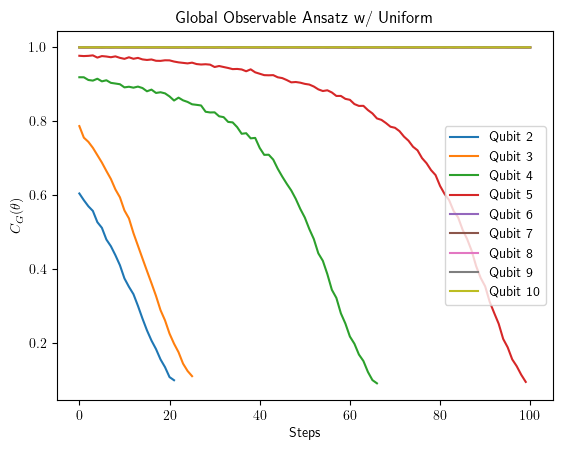

In [13]:
for q in qubits:
    plt.plot(np.arange(len(dense_param_runs[q])), dense_param_runs[q], label=f'Qubit {q}')
plt.legend()
plt.title('Global Observable Ansatz w/ Uniform')
plt.ylabel(r'$C_{G}(\theta)$')
plt.xlabel('Steps')
plt.savefig('global_obs_unif_unpruned.pdf', dpi=300, bbox_inches='tight')

Text(0.5, 0, 'Steps')

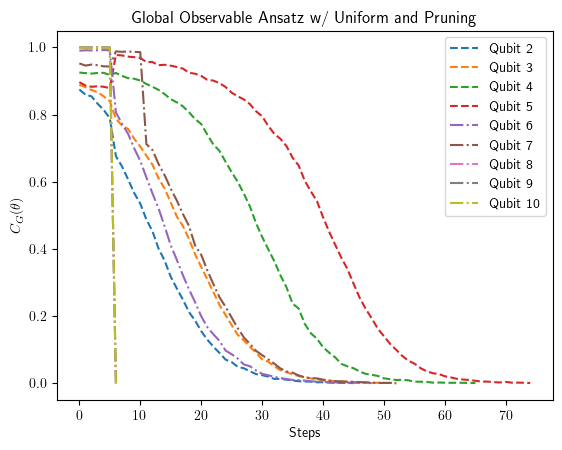

In [31]:
for q in qubits:
    ls = '--' if q < 6 else 'dashdot'
    plt.plot(np.arange(len(pruning_param_runs[q][0])), 
             pruning_param_runs[q][0], linestyle=ls, label=f'Qubit {q}')
plt.legend()
plt.title('Global Observable Ansatz w/ Uniform and Pruning')
plt.ylabel(r'$C_{G}(\theta)$')
plt.xlabel('Steps')
# plt.savefig('pruned_param_pruning.pdf', dpi=300, bbox_inches='tight')

In [38]:
pruning_param_runs[6][1]

0.16666666666666663

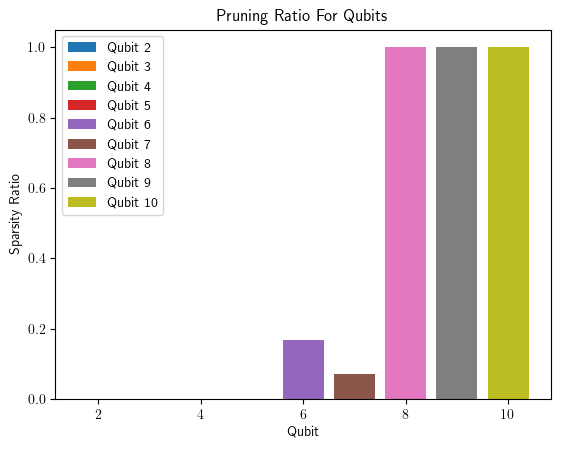

In [33]:
for q in qubits:
    plt.bar(q, pruning_param_runs[q][1], label=f'Qubit {q}')
plt.legend()
plt.title('Pruning Ratio For Qubits')
plt.ylabel('Sparsity Ratio')
plt.xlabel('Qubit')
plt.savefig('pruning_ratio_global_ansatz.pdf', dpi=300, bbox_inches='tight')